In [1]:
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tensorflow import keras
from datetime import datetime
import random
from typing import List

In [2]:
samples = 500

m = 2
xs = [i * m for i in range(samples)]
c = 50

ms = [m for _ in range(samples)]
cs = [c for _ in range(samples)]
ys = [m * x + c for x in xs]
noise = [random.randint(0,50) for _ in range(samples)]

data = {
    'ms': ms,
    'xs': xs,
    'cs': cs,
    'noise': noise, 
    'ys': ys
}

df = pd.DataFrame(data=data)
df.head(5)

,ms,xs,cs,noise,ys
0,2,0,50,43,50
1,2,2,50,25,54
2,2,4,50,47,58
3,2,6,50,23,62
4,2,8,50,5,66


In [3]:
def maximum_absolute_scaling(df):
    df_scaled = df.copy()
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

In [4]:
scaled = maximum_absolute_scaling(df)
scaled.head(5)

,ms,xs,cs,noise,ys
0,1.0,0.000000,1.0,0.86,0.024438
1,1.0,0.002004,1.0,0.50,0.026393
2,1.0,0.004008,1.0,0.94,0.028348
3,1.0,0.006012,1.0,0.46,0.030303
4,1.0,0.008016,1.0,0.10,0.032258


In [5]:
columns = ['ms', 'xs', 'cs', 'noise']
# columns = ['ms', 'xs', 'cs']

X_train = df[columns]
y_train = df['ys']

X_train.shape

(500, 4)

In [6]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(units=4, input_shape=[4]))
# model.add(tf.keras.layers.Dense(units=4, input_shape=[4]))
# model.add(tf.keras.layers.Dense(units=1))
# model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(0.5), loss='mean_squared_error')

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=[4]))
model.add(tf.keras.layers.Dense(units=4, input_shape=[4]))
model.add(tf.keras.layers.Dense(units=1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [7]:
epochs_hist = model.fit(X_train, y_train, epochs=500)

Epoch 1/500
16/16 [==============================] - 1s 8ms/step - loss: 44037.0859
Epoch 2/500
16/16 [==============================] - 0s 6ms/step - loss: 14635.1504
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 4240.8364
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 2798.5020
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 2763.6995
Epoch 6/500
16/16 [==============================] - 0s 6ms/step - loss: 2666.3667
Epoch 7/500
16/16 [==============================] - 0s 6ms/step - loss: 2625.9756
Epoch 8/500
16/16 [==============================] - 0s 5ms/step - loss: 2582.9282
Epoch 9/500
16/16 [==============================] - 0s 6ms/step - loss: 2544.2410
Epoch 10/500
16/16 [==============================] - 0s 5ms/step - loss: 2501.7466
Epoch 11/500
16/16 [==============================] - 0s 6ms/step - loss: 2460.5520
Epoch 12/500
16/16 [==============================] - 0s 6ms/step - loss: 2412.8652

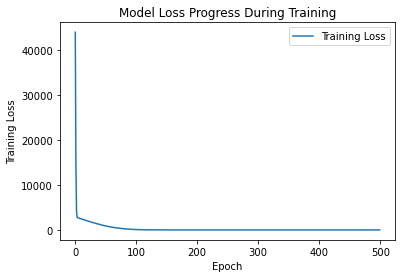

In [8]:
plt.plot(epochs_hist.history['loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'])

In [9]:
def equation(m, x, c):
    return m * x + c

In [10]:
def test_with_equation(df):
    df = df.copy()
    df['test'] = df.apply(lambda x: equation(x['ms'], x["xs"], x["cs"]), axis=1)
    return df

In [11]:
x = 10
tdata = {
    'ms': [2,2,2,2],
    'xs': [0,2,4,6],
    'cs': [50,50,50,50],
    'noise': [123,384,2,23],
    'expected': [50,54,58,62]
}
test =  pd.DataFrame(tdata)
test

,ms,xs,cs,noise,expected
0,2,0,50,123,50
1,2,2,50,384,54
2,2,4,50,2,58
3,2,6,50,23,62


In [12]:
model_test = test[['ms', 'xs', 'cs', 'noise']]

model.predict(model_test)

1/1 [==============================] - 0s 59ms/step


array([[49.999985],
       [53.99998 ],
       [58.000004],
       [62.      ]], dtype=float32)

In [13]:
res = test_with_equation(test)
res

,ms,xs,cs,noise,expected,test
0,2,0,50,123,50,50
1,2,2,50,384,54,54
2,2,4,50,2,58,58
3,2,6,50,23,62,62


In [14]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [15]:
conn = Neo4jConnection(uri="neo4j://localhost:7687", user="neo4j", pwd="password")

In [78]:
all_weights = [model.layers[i].get_weights()[0].tolist() for i in range(len(model.layers))]
all_biases = [model.layers[i].bias.numpy().tolist() for i in range(len(model.layers))]
weights = all_weights.copy()
biases = all_biases.copy()
output_w = weights.pop()
output_b = biases.pop()

In [17]:
def input_nodes():
    for i in range(len(columns)):
        query = f"CREATE (i: Input {{name: '{columns[i]}'}})"
        conn.query(query, db="nndb")

In [18]:
def hidden_layer_nodes():
    for i in range(len(biases)):
        for j in range(len(biases[i])):
            query = f"CREATE (h: HiddenLayer{i} {{bias: {biases[i][j]}, name: 'hidden_layer_{i}_node_{j}'}})"
            conn.query(query, db="nndb")

In [19]:
def output_nodes():
    query = f"CREATE (o: Output {{bias: {output_b[0]}, name: 'output_node'}})"
    conn.query(query, db="nndb")

In [20]:
def input_weights():
    in_weights = weights[0]
    for i in range(len(in_weights)):
        for j in range(len(in_weights[i])):
            query = f"""
                MATCH
                    (i: Input),
                    (h: HiddenLayer0)
                WHERE i.name = '{columns[i]}'
                AND h.name = 'hidden_layer_0_node_{j}'
                CREATE (i)-[w: Weight {{weight: {in_weights[i][j]}}}]->(h)
                RETURN i, h
            """
            conn.query(query, db="nndb")

In [21]:
def output_weights():
    last_hidden_layer = len(biases) - 1
    for i in range(len(output_w)):
        query = f"""
            MATCH 
                (h: HiddenLayer{last_hidden_layer}),
                (o: Output)
            WHERE h.name = 'hidden_layer_{last_hidden_layer}_node_{i}'
            CREATE (h)-[w: Weight {{weight: {output_w[i][0]}}}]->(o)
        """
        conn.query(query, db="nndb")

In [22]:
def hidden_layer_weights():
    for i in range(len(weights)):
        if i == 0:
            continue
        for j in range(len(weights[i])):
            for k in range(len(weights[i][j])):
                query = f"""
                    MATCH
                        (h0: HiddenLayer{i - 1}),
                        (h1: HiddenLayer{i})
                    WHERE h0.name = 'hidden_layer_{i - 1}_node_{j}'
                    AND h1.name = 'hidden_layer_{i}_node_{k}'
                    CREATE (h0)-[w: Weight {{weight: {weights[i][j][k]}}}]->(h1)
                """
                conn.query(query, db="nndb") 
            

In [23]:
conn.query("CREATE OR REPLACE DATABASE nndb")
input_nodes()
hidden_layer_nodes()
output_nodes()
input_weights()
hidden_layer_weights()
output_weights()

In [77]:
all_weights

[[[-0.043730027973651886, 0.1517382264137268, 0.43230947852134705],
  [0.40325430035591125, -0.9136365056037903, 0.38572221994400024],
  [-0.1078452616930008, 0.4543115198612213, 1.4651963710784912]],
 [[-0.343445748090744, 0.5688265562057495, 0.32832232117652893],
  [0.522747814655304, -0.20265227556228638, -0.37623313069343567],
  [0.7028365135192871, 0.24457916617393494, -0.4518664479255676]],
 [[-0.02284279838204384], [0.7547040581703186], [0.2837214767932892]]]

In [41]:
all_biases

[[0.40301111340522766, -0.3964817523956299, 0.8168851733207703],
 [-0.25853756070137024, 0.41795361042022705, 0.36834824085235596],
 [0.4082064628601074]]

In [75]:
def remove_weights(weights: List, index: int) -> List:
    output_weights = []
    for weight_list in weights:
        print(weight_list)
        try:
            check = weight_list.pop(index)
            if weight_list != []:
                output_weights.append(weight_list)
        except IndexError:
            print("INDEX ERROR")
            pass
    
    return output_weights

In [79]:
all_weights = [model.layers[i].get_weights()[0].tolist() for i in range(len(model.layers))]


new_weights = [remove_weights(weight_list,  3) for weight_list in all_weights] 
new_weights

[-0.043730027973651886, 0.1517382264137268, 0.43230947852134705, 0.46539509296417236]
CHECK: 0.46539509296417236
APPENDING
[0.40325430035591125, -0.9136365056037903, 0.38572221994400024, -0.3450317084789276]
CHECK: -0.3450317084789276
APPENDING
[-0.1078452616930008, 0.4543115198612213, 1.4651963710784912, 1.194019079208374]
CHECK: 1.194019079208374
APPENDING
[0.14909566938877106, -0.3864486813545227, -0.5928345322608948, -0.6174831390380859]
CHECK: -0.6174831390380859
APPENDING
[-0.343445748090744, 0.5688265562057495, 0.32832232117652893, -0.8581803441047668]
CHECK: -0.8581803441047668
APPENDING
[0.522747814655304, -0.20265227556228638, -0.37623313069343567, 0.8658285140991211]
CHECK: 0.8658285140991211
APPENDING
[0.7028365135192871, 0.24457916617393494, -0.4518664479255676, -0.7794046401977539]
CHECK: -0.7794046401977539
APPENDING
[-0.6613671183586121, 0.14852173626422882, 0.19029247760772705, -0.07047707587480545]
CHECK: -0.07047707587480545
APPENDING
[-0.02284279838204384]
INDEX ERR

[[[-0.043730027973651886, 0.1517382264137268, 0.43230947852134705],
  [0.40325430035591125, -0.9136365056037903, 0.38572221994400024],
  [-0.1078452616930008, 0.4543115198612213, 1.4651963710784912],
  [0.14909566938877106, -0.3864486813545227, -0.5928345322608948]],
 [[-0.343445748090744, 0.5688265562057495, 0.32832232117652893],
  [0.522747814655304, -0.20265227556228638, -0.37623313069343567],
  [0.7028365135192871, 0.24457916617393494, -0.4518664479255676],
  [-0.6613671183586121, 0.14852173626422882, 0.19029247760772705]],
 []]